In [81]:
import numpy as np
import cv2
import skimage
from skimage import io
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.morphology import reconstruction
from scipy import stats
from statistics import mean 
import imutils

from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform

In [172]:
img = cv2.imread('sem_1.jpg',0)

In [3]:
#Pretreatment for the boundary detection
image = img
image = gaussian_filter(image, 1)
seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
mask = image
dilated = reconstruction(seed, mask, method='dilation')

In [170]:
def boundary_detection(img, thres = 20):
    '''
    thres: threshold to distinguish the scale bar background with particle background by grey scale
    for now only work for SEM img, needs update if apply to different imgs
    scan from upper to bottom, also needs update if need scan from left to right
    '''
    mode_list = []
    for line in range(len(img)):
        mode = stats.mode(img[line])
        mode_list.append(int(mode[0]))
        
        if line >= 1:
            mode_mean = mean(mode_list)
            if mode_mean - int(mode[0]) >= thres:
                boundary = line
                break
        
    return boundary

In [171]:
def img_filter(img, thres = 20):
    '''
    Pretreatment for the picture to get a dilated and boundary cutted image
    '''
    #Pretreatment for the boundary detection
    image = img
    image = gaussian_filter(image, 1)
    seed = np.copy(image)
    seed[1:-1, 1:-1] = image.min()
    mask = image
    dilated = reconstruction(seed, mask, method='dilation')
    
    image = mask - dilated
    bound = boundary_detection(dilated)
    img_c = image[:bound,:]
    img_c = img_c.astype(np.uint8)
    
    return img_c

In [176]:
img_filtered = img_filter(img)

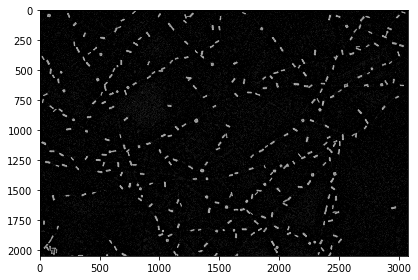

In [177]:
io.imshow(img_filtered)

In [6]:
#kernel = np.ones((8,8))
#kernel = kernel / 64

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))

In [7]:
#img_f = cv2.filter2D(img_c, -1, kernel)

dilated = cv2.dilate(img_c, kernel)

In [113]:
poly_c = dilated.copy()
hull_c = dilated.copy()
_, threshold = cv2.threshold(dilated, dilated.max()/4, dilated.max(), cv2.THRESH_BINARY)
contours, _=cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
edge = []
for cnt in contours:
    '''
    More: add information for particle segmentation and area calculation
    output: shapetype, particle #, area of individuals
    '''
    approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True) #Tunning needed for the coeffecients
    hull = cv2.convexHull(approx)
    #cv2.drawContours(poly_c, approx, 0, (80), 3)
    cv2.drawContours(hull_c, hull, 0, (80), 3)
    edge.append(len(hull))

337


(array([  5.,   0.,   2.,   3.,  13.,  58., 130.,  82.,  38.,   6.]),
 array([ 4. ,  4.9,  5.8,  6.7,  7.6,  8.5,  9.4, 10.3, 11.2, 12.1, 13. ]),
 <a list of 10 Patch objects>)

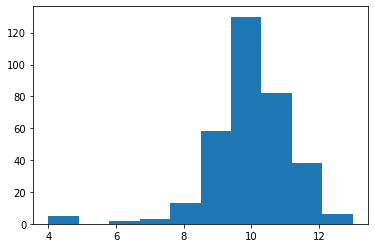

In [114]:
print(len(edge))
plt.hist(edge)

In [178]:
def shape_radar(img, noise_factor = 4, thresh_mono = 30, thresh_di = 90, thres_poly = 130):
    '''
    return a annotated img from setted threshold
    '''
    #Another layer of dilation to improve the edge detection, optional
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
    dilated = cv2.dilate(img, kernel)
    
    #Get contours
    _, threshold = cv2.threshold(dilated, dilated.max()/noise_factor, dilated.max(), cv2.THRESH_BINARY)
    contours, _=cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #Create plot, copy the img and convert into color scale
    plt.figure(figsize=(20,16))
    dilated_c = dilated.copy()
    dilated_c = cv2.cvtColor(dilated_c,cv2.COLOR_GRAY2RGB)
    

    for c in contours:
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        #approx = cv2.approxPolyDP(c, 0.05 * cv2.arcLength(c, True), True) #Tunning needed for the coeffecients
        #hull = cv2.convexHull(approx)
        #cv2.drawContours(dilated_c, hull, -1, (100), 5)
        #print(len(hull))
        if len(c) <= thresh_di and len(c) > thresh_mono:
            #cv2.putText(dilated_c, str(len(c)), (c[0][0][0], c[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255), 5) #Use str(len(c)) instead of text
            cv2.drawContours(dilated_c, [box], 0, (255, 255, 255), 3)
        elif len(c) > thresh_di and len(c) <= thres_poly:
            cv2.putText(dilated_c, 'dimer', (c[0][0][0], c[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(255, 0, 0), 3) #Use str(len(c)) instead of text
            cv2.drawContours(dilated_c, [box], 0, (255, 0, 0), 3)
        elif len(c) > thres_poly:
            cv2.putText(dilated_c, 'polymer', (c[0][0][0], c[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(0, 255, 0), 3) #Use str(len(c)) instead of text
            cv2.drawContours(dilated_c, [box], 0, (0, 255, 0), 3)

    return dilated_c


In [180]:
img_shape = shape_radar(img_filtered)

<Figure size 1440x1152 with 0 Axes>

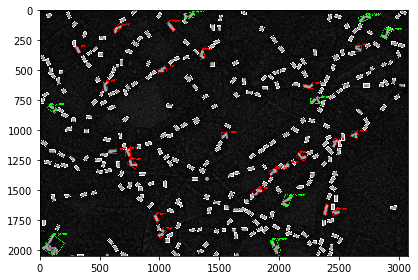

In [181]:
io.imshow(img_shape)

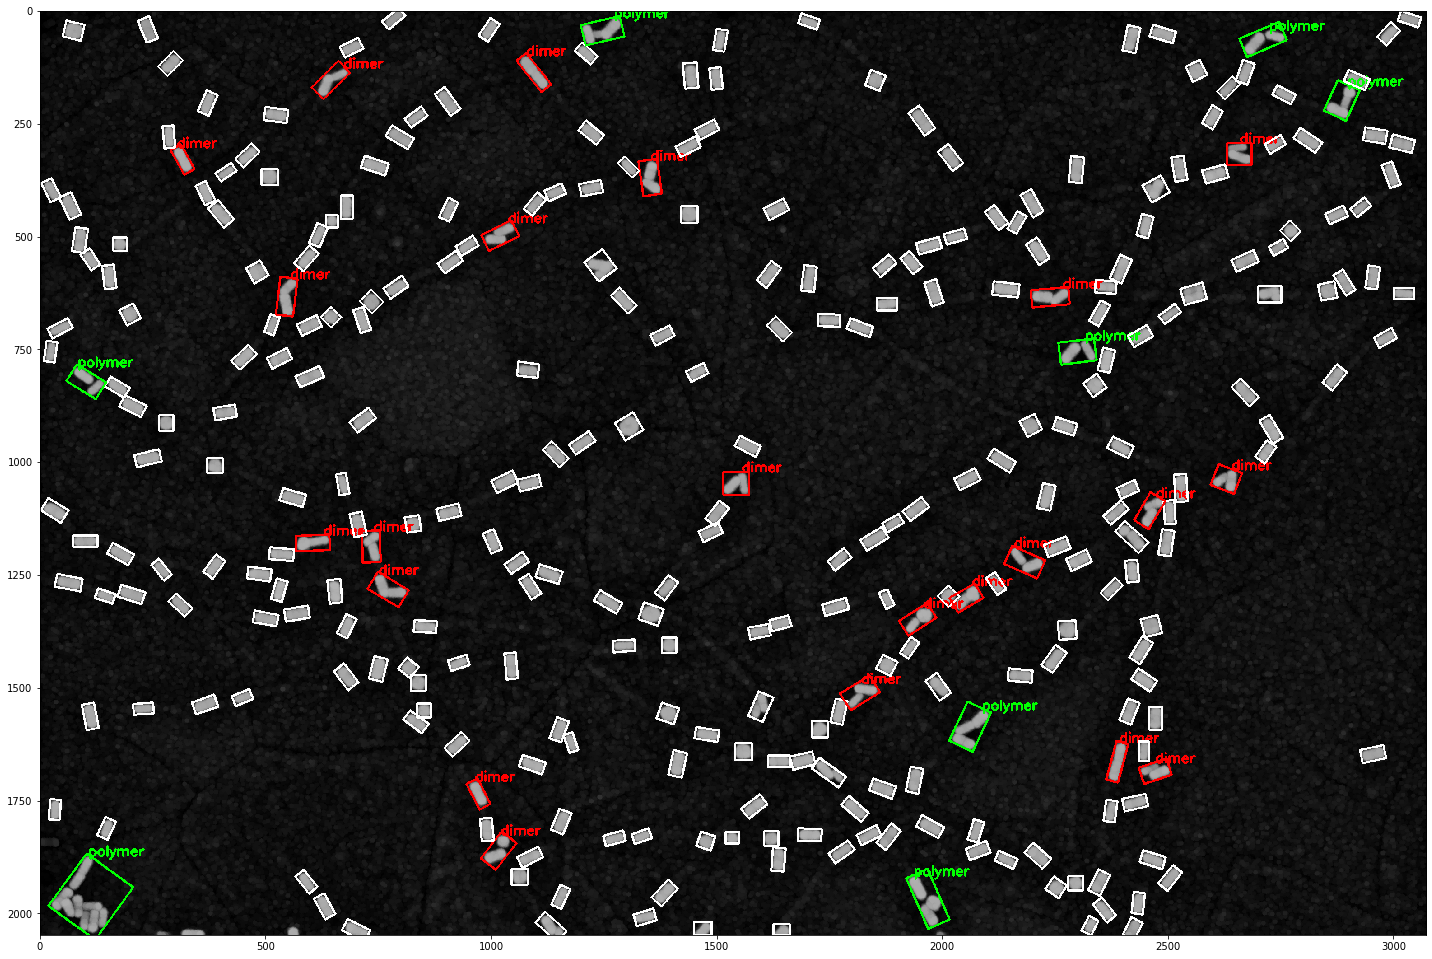

In [169]:
plt.figure(figsize=(20,16))
dilated_c = dilated.copy()
dilated_c = cv2.cvtColor(dilated_c,cv2.COLOR_GRAY2RGB)

for c in contours:
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    #approx = cv2.approxPolyDP(c, 0.05 * cv2.arcLength(c, True), True) #Tunning needed for the coeffecients
    #hull = cv2.convexHull(approx)
    #cv2.drawContours(dilated_c, hull, -1, (100), 5)
    #print(len(hull))
    if len(c) <= 90 and len(c) > 30:
        #cv2.putText(dilated_c, str(len(c)), (c[0][0][0], c[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255), 5) #Use str(len(c)) instead of text
        cv2.drawContours(dilated_c, [box], 0, (255, 255, 255), 3)
    elif len(c) > 90 and len(c) <= 130:
        cv2.putText(dilated_c, 'dimer', (c[0][0][0], c[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(255, 0, 0), 3) #Use str(len(c)) instead of text
        cv2.drawContours(dilated_c, [box], 0, (255, 0, 0), 3)
    elif len(c) > 130:
        cv2.putText(dilated_c, 'polymer', (c[0][0][0], c[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(0, 255, 0), 3) #Use str(len(c)) instead of text
        cv2.drawContours(dilated_c, [box], 0, (0, 255, 0), 3)

io.imshow(dilated_c)


337


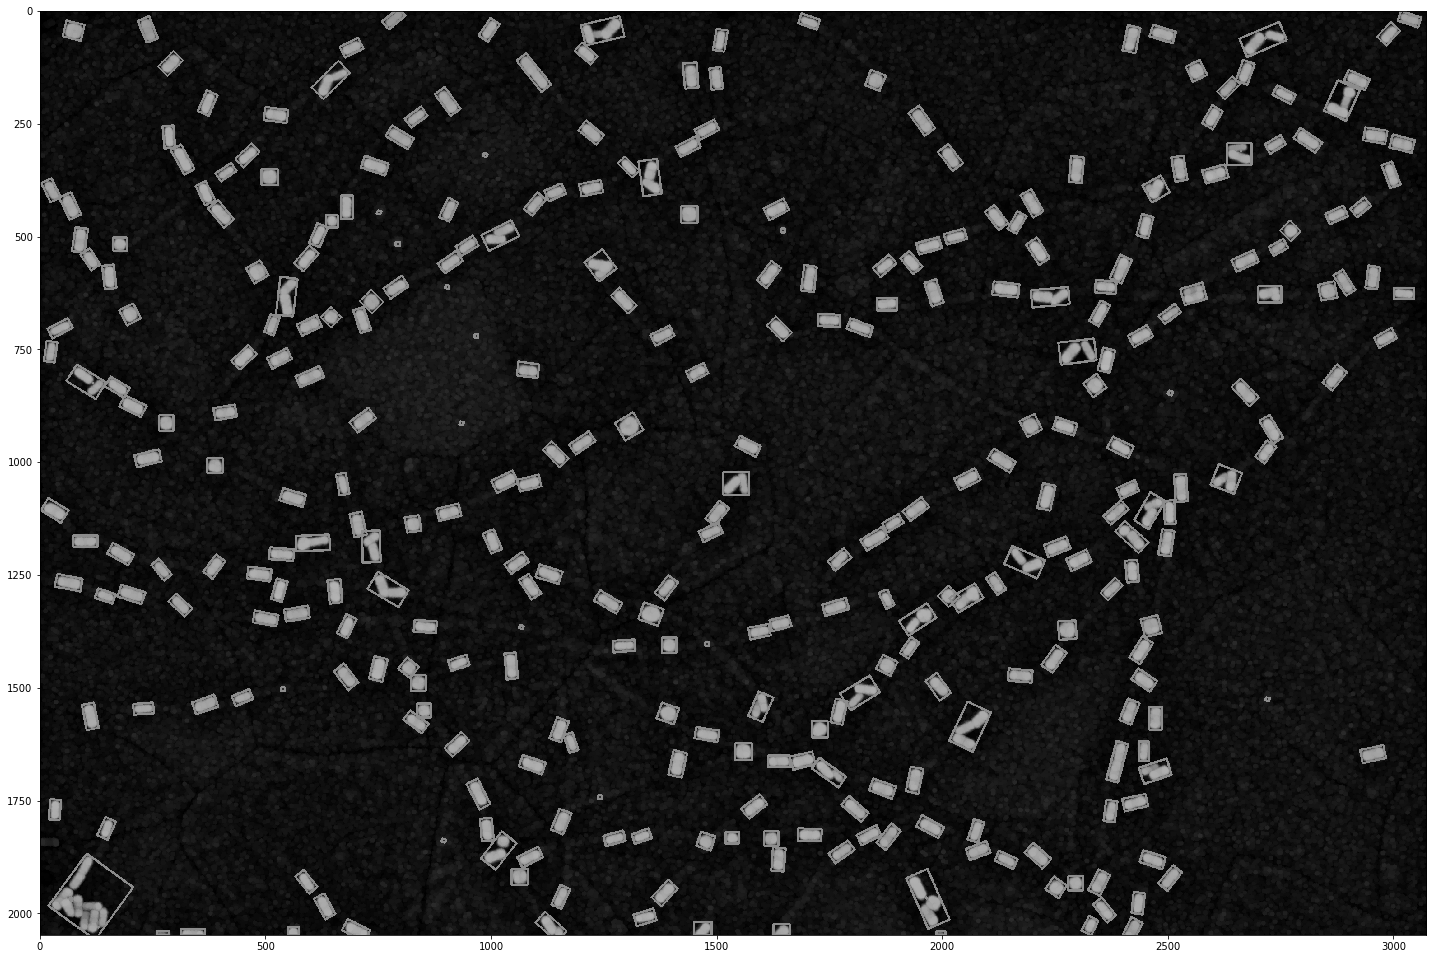

In [155]:
plt.figure(figsize=(20,16))
dilated_c = dilated.copy()
count_box = 0
for c in contours:
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(dilated_c, [box], 0, (140), 3)
    count_box += 1
    #Question part
    approx = cv2.approxPolyDP(c, 0.01 * cv2.arcLength(c, True), True) #Tunning needed for the coeffecients
    #hull = cv2.convexHull(approx)
    #cv2.drawContours(dilated_c, c, -1, (100), 2)

print(count_box)
io.imshow(dilated_c)
#plt.xlim(500,1000)
#plt.ylim(1250,1500)

In [77]:
def corner_detection(sem_data):
    """
    This function is used to find the length pixel of the scale bar.
    The imput should be just bottom part of the initial SEM image.
    This function uses the return result of boundary_detection.
    """
    #find the bottom part of the SEM image. Here we used the return refunction 
    ime = sem_data
    
    tform = AffineTransform()
    image = warp(ime,tform.inverse)
    coords = corner_peaks(corner_harris(image, k=0.1, sigma=3))
    coords_subpix = corner_subpix(image, coords)
    #get the length of the scale bar
    length_scale_bar = abs(coords[0][1] - coords[1][1])
    #plot
    fig, ax = plt.subplots(figsize=(15,15))
    ax.imshow(image, cmap=plt.cm.gray)
    ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
            linestyle='None', markersize=6)
    #ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=10)
    plt.show()
    return length_scale_bar

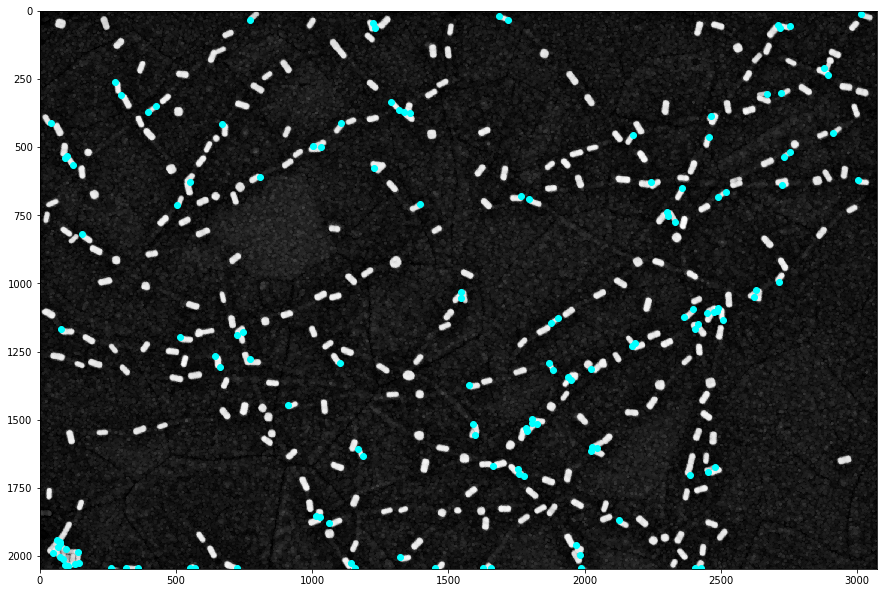

1329

In [78]:
corner_detection(dilated)

# Below is the official trail

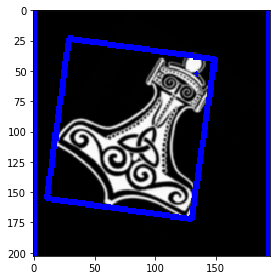

In [58]:
import cv2
import numpy as np

img = cv2.pyrDown(cv2.imread("hammer.png", cv2.IMREAD_UNCHANGED))

ret, thresh = cv2.threshold(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY) , 127, 255, cv2.THRESH_BINARY)
contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for c in contours:
# find bounding box coordinates
    x,y,w,h = cv2.boundingRect(c)
    #cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)

    # find minimum area
    rect = cv2.minAreaRect(c)
    # calculate coordinates of the minimum area rectangle
    box = cv2.boxPoints(rect)
    # normalize coordinates to integers
    box = np.int0(box)
    # draw contours
    cv2.drawContours(img, [box], 0, (0,0, 255), 3)
    #cv2.drawContours(img, c, -1, (0,0, 255), 3)
    '''
    # calculate center and radius of minimum enclosing circle
    (x,y),radius = cv2.minEnclosingCircle(c)
    # cast to integers
    center = (int(x),int(y))
    radius = int(radius)
    # draw the circle
    img = cv2.circle(img,center,radius,(0,255,0),2)
    '''

#cv2.drawContours(img.copy(), contours, -1, (255, 0, 0), 1)
io.imshow(img.copy())